In [1]:
import torch

In [2]:
import os
from PIL import Image
from torchvision import transforms
from torchvision.datasets import DatasetFolder
import cv2
import numpy as np


def load_image(img_path:str):    
        np_img = cv2.imread(img_path) #CV2 to open and convert BMP mages into NUMPY    
        #np_img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        return Image.fromarray(np_img)  #we need Image for the transforms to work correctly

dset = DatasetFolder(root='NEUdata', loader = load_image, extensions = ('.bmp',))


# We need to write a transform to make it compatible with resnet18 (size 224x224x3, and type tensor)

In [3]:
from torchvision import transforms

transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(
      mean=[0.485, 0.456, 0.406],
      std=[0.229, 0.224, 0.225])])

dset = DatasetFolder(root='NEUdata', loader = load_image, extensions = ('.bmp',), transform = transform)

### Note that load_image  needed to return a PIL.Image for the transforms to be correctly applied


In [4]:
from torch.utils.data import random_split

train_set, val_set = random_split(
                      dset, 
                      [1200, 600])

trainloader = torch.utils.data.DataLoader(
                    train_set, 
                    batch_size=16, 
                    shuffle=True)

valloader = torch.utils.data.DataLoader(
                    val_set, 
                    batch_size=16, 
                    shuffle=True)

print(len(trainloader))
# out: 2500
print(len(valloader))
# out: 625

75
38


 ### We are going to illustrate transfer learning now
Transfer starts with a pretrained model from the torchvision library. The pretrained model will be resnet18. This model is trained on ImageNet 1K (this is the default for resnet18: DEFAULT = IMAGENET1K_V1)
The fact that ImageNet consists of RGB images of size 224 x 224 demanded our data resizing in the transform

In [5]:
import torchvision.models as models
import torch.nn as nn
from torchinfo import summary

orig_model = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)
summary(orig_model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [16, 1000]                --
+ Conv2d: 1-1                            [16, 64, 112, 112]        9,408
+ BatchNorm2d: 1-2                       [16, 64, 112, 112]        128
+ ReLU: 1-3                              [16, 64, 112, 112]        --
+ MaxPool2d: 1-4                         [16, 64, 56, 56]          --
+ Sequential: 1-5                        [16, 64, 56, 56]          --
|    + BasicBlock: 2-1                   [16, 64, 56, 56]          --
|    |    + Conv2d: 3-1                  [16, 64, 56, 56]          36,864
|    |    + BatchNorm2d: 3-2             [16, 64, 56, 56]          128
|    |    + ReLU: 3-3                    [16, 64, 56, 56]          --
|    |    + Conv2d: 3-4                  [16, 64, 56, 56]          36,864
|    |    + BatchNorm2d: 3-5             [16, 64, 56, 56]          128
|    |    + ReLU: 3-6                    [16, 64, 56, 56]          --
|

### notice that the last layer of the resnet18 is a linear layer with output size 1000

We will first deepcopy  orig_model (where we instantiated resnet18 with pretrained weights): this will create an INDEPENDENT graph

Then just replace model.fc with the linear layer


In [6]:
import copy
alt_model = copy.deepcopy(orig_model)
alt_model.fc = nn.Linear(512,6)

In [7]:
from torch import optim
from torch import nn
import torch.optim.lr_scheduler as lr_scheduler

torch.cuda.empty_cache()
import gc
gc.collect()
criterion = nn.CrossEntropyLoss()
device = "cuda"
res_model = alt_model.to(device)

optimizer = optim.SGD(res_model.parameters(), 
                      lr=0.001, 
                      momentum=0.9)
 
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.25, total_iters=10)


#from torch.utils.tensorboard import SummaryWriter



N_EPOCHS = 20
tr_loss_hist = []
val_loss_hist = []
for epoch in range(N_EPOCHS):

    # Training 
    train_loss = 0.0
    res_model.train() # <1>
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = res_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    # Validation
    val_loss = 0.0
    res_model.eval() # <2>
    for inputs, labels in valloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = res_model(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()

    print("Epoch: {} Train Loss: {} Val Loss: {}".format(
                  epoch, 
                  train_loss/len(trainloader), 
                  val_loss/len(valloader)))
    tr_loss_hist.append(train_loss/len(trainloader))
    val_loss_hist.append(val_loss/len(valloader))

Epoch: 0 Train Loss: 0.86839040239652 Val Loss: 0.2711560420299831
Epoch: 1 Train Loss: 0.2905345649520556 Val Loss: 0.11014441366454489
Epoch: 2 Train Loss: 0.15253015433748562 Val Loss: 0.07216688725901277
Epoch: 3 Train Loss: 0.10819738658765952 Val Loss: 0.043451992451752484
Epoch: 4 Train Loss: 0.09147247331837813 Val Loss: 0.03488477302323047
Epoch: 5 Train Loss: 0.08646671901146571 Val Loss: 0.03215210247588785
Epoch: 6 Train Loss: 0.06472198477635781 Val Loss: 0.021963810474660835
Epoch: 7 Train Loss: 0.050643529867132504 Val Loss: 0.018620448058324034
Epoch: 8 Train Loss: 0.041300604057808714 Val Loss: 0.020254027245468216
Epoch: 9 Train Loss: 0.03893043636654814 Val Loss: 0.013301607497085473
Epoch: 10 Train Loss: 0.03911278902242581 Val Loss: 0.016651643777119095
Epoch: 11 Train Loss: 0.039472736346845824 Val Loss: 0.01426283301368944
Epoch: 12 Train Loss: 0.03314000528926651 Val Loss: 0.01176886742101296
Epoch: 13 Train Loss: 0.028371829359481734 Val Loss: 0.009568618031488

Text(0.5, 1.0, 'Loss Curves')

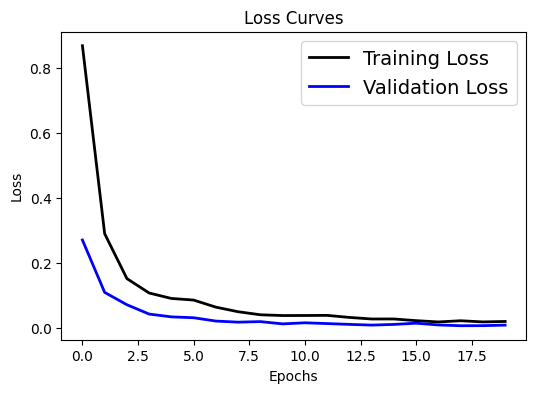

In [8]:
import matplotlib.pyplot as plt

# Plotting the loss curve
plt.figure(figsize=[6,4])
plt.plot(tr_loss_hist, 'black', linewidth=2.0)
plt.plot(val_loss_hist, 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

#### This is a different way of changing the resnet18

Let's get rid of the last layer of the resnet18 (output size 1000), because we have only 6 classes!

Plus, add the FlattenLayer to see what is the linearized size of the last AvgPool

We will use this shortened model (vec_model) to build upon it later, but first we will **freeze its parameters** (disable further training)


In [9]:
layers = list(orig_model.children())[:-1]  #get all the layers except the last one
layers.append(nn.Flatten())   
vec_model = nn.Sequential(*layers)
for param in vec_model.parameters():
    param.requires_grad = False

## Here we will add linear layer to the frozen vec_model

In [10]:
layers = list(vec_model.children())  #get all the layers except the last one
layers.append(nn.Linear(512,6))
vec_model = nn.Sequential(*layers)
summary(vec_model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [16, 6]                   --
+ Conv2d: 1-1                            [16, 64, 112, 112]        (9,408)
+ BatchNorm2d: 1-2                       [16, 64, 112, 112]        (128)
+ ReLU: 1-3                              [16, 64, 112, 112]        --
+ MaxPool2d: 1-4                         [16, 64, 56, 56]          --
+ Sequential: 1-5                        [16, 64, 56, 56]          --
|    + BasicBlock: 2-1                   [16, 64, 56, 56]          --
|    |    + Conv2d: 3-1                  [16, 64, 56, 56]          (36,864)
|    |    + BatchNorm2d: 3-2             [16, 64, 56, 56]          (128)
|    |    + ReLU: 3-3                    [16, 64, 56, 56]          --
|    |    + Conv2d: 3-4                  [16, 64, 56, 56]          (36,864)
|    |    + BatchNorm2d: 3-5             [16, 64, 56, 56]          (128)
|    |    + ReLU: 3-6                    [16, 64, 56, 56]  

#### Train vec_model

In [11]:
from torch import optim
from torch import nn
import torch.optim.lr_scheduler as lr_scheduler

criterion = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
v_model = vec_model.to(device)

optimizer = optim.SGD(v_model.parameters(), 
                      lr=0.001, 
                      momentum=0.9)
 
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.25, total_iters=10)


#from torch.utils.tensorboard import SummaryWriter

N_EPOCHS = 20
tr_loss_hist = []
val_loss_hist = []
for epoch in range(N_EPOCHS):

    # Training 
    train_loss = 0.0
    v_model.train() # <1>
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = v_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    # Validation
    val_loss = 0.0
    v_model.eval() # <2>
    for inputs, labels in valloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = v_model(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()

    print("Epoch: {} Train Loss: {} Val Loss: {}".format(
                  epoch, 
                  train_loss/len(trainloader), 
                  val_loss/len(valloader)))
    tr_loss_hist.append(train_loss/len(trainloader))
    val_loss_hist.append(val_loss/len(valloader))

Epoch: 0 Train Loss: 1.3641700299580892 Val Loss: 0.9124178776615545
Epoch: 1 Train Loss: 0.7420038338502248 Val Loss: 0.5015062658410323
Epoch: 2 Train Loss: 0.5153041589260101 Val Loss: 0.3753414408941018
Epoch: 3 Train Loss: 0.4384641236066818 Val Loss: 0.2868606942264657
Epoch: 4 Train Loss: 0.3579562139511108 Val Loss: 0.2488892429361218
Epoch: 5 Train Loss: 0.32255962391694387 Val Loss: 0.21531121334747264
Epoch: 6 Train Loss: 0.2876572682460149 Val Loss: 0.18955993220994347
Epoch: 7 Train Loss: 0.26086720675230024 Val Loss: 0.17765028676704356
Epoch: 8 Train Loss: 0.22600182016690573 Val Loss: 0.1594448738584393
Epoch: 9 Train Loss: 0.22363721763094266 Val Loss: 0.14796551395403712
Epoch: 10 Train Loss: 0.20546104202667873 Val Loss: 0.14287821497572095
Epoch: 11 Train Loss: 0.2044870809217294 Val Loss: 0.13528570522995373
Epoch: 12 Train Loss: 0.18730496476093927 Val Loss: 0.12121029531485156
Epoch: 13 Train Loss: 0.19280708541472752 Val Loss: 0.114228148797625
Epoch: 14 Train L

Text(0.5, 1.0, 'Loss Curves')

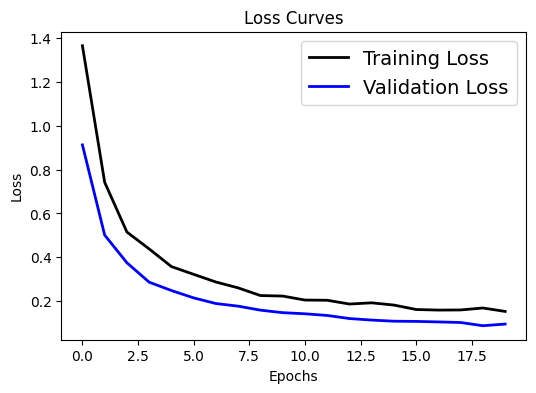

In [12]:
import matplotlib.pyplot as plt

# Plotting the loss curve
plt.figure(figsize=[6,4])
plt.plot(tr_loss_hist, 'black', linewidth=2.0)
plt.plot(val_loss_hist, 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

Get dataset

In [13]:
from utils import DatasetStatistics
from torch.utils.data import DataLoader

neu_test = DatasetFolder(root='RowanDLclassNEA/NEUdata_split/Test', loader = load_image, extensions = ('.bmp',), transform=transforms.ToTensor())
test_loader = DataLoader(neu_test, batch_size=32, shuffle=False)

# utillity functions for calculating mean and stanrdard deviation of RGB channnels
stats_calc = DatasetStatistics(test_loader)

mean = stats_calc.calculate_mean()
std = stats_calc.calculate_std(mean)

test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(
                mean=mean,
                std=std)
            ])

neu_test = DatasetFolder(root='RowanDLclassNEA/NEUdata_split/Test', loader = load_image, extensions = ('.bmp',), transform=test_transform)
test_loader = DataLoader(neu_test, batch_size=32, shuffle=False)

Test vec_model

In [14]:
num_correct = 0.0

for x_test_batch, y_test_batch in test_loader:

    v_model.eval()
    y_test_batch = y_test_batch.to(device)
    x_test_batch = x_test_batch.to(device)

    y_pred_batch = v_model(x_test_batch)
    _, predicted = torch.max(y_pred_batch, 1)
    num_correct += (predicted == y_test_batch).float().sum()

vec_accuracy = num_correct/(len(test_loader)*test_loader.batch_size)

Test Resnet18

In [15]:
num_correct = 0.0

for x_test_batch, y_test_batch in test_loader:

    res_model.eval()
    y_test_batch = y_test_batch.to(device)
    x_test_batch = x_test_batch.to(device)

    y_pred_batch = res_model(x_test_batch)
    _, predicted = torch.max(y_pred_batch, 1)
    num_correct += (predicted == y_test_batch).float().sum()

res_accuracy = num_correct/(len(test_loader)*test_loader.batch_size)

print("Resnet18 Test Accuracy: {}".format(res_accuracy))
print("Vec_model Test Accuracy: {}".format(vec_accuracy))

Resnet18 Test Accuracy: 0.9375
Vec_model Test Accuracy: 0.2447916716337204
